In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy

In [2]:
from sklearn.model_selection import KFold, cross_val_predict,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV

In [3]:
path = os.getcwd()
dataset = 'bodyfat.csv'
path = os.getcwd() + '\\' + dataset

df = pd.read_csv(path)
Age = df['Age']
#df.drop(columns=['Age'], inplace=True) ##

df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


#https://www.kaggle.com/fedesoriano/body-fat-prediction-dataset

The percentage of body fat for an individual can be estimated once body density has been determined. Folks (e.g. Siri (1956)) assume that the body consists
of two components - lean body tissue and fat tissue. Letting:

D = Body Density (gm/cm^3) - This is measured - hydrostatic weighing


A = proportion of lean body tissue  <br>
B = proportion of fat tissue (A+B=1)


a = density of lean body tissue (gm/cm^3) <br>
b = density of fat tissue (gm/cm^3) - fat floats in water so (Wa - Ww) = lean body mass

a and b have average value:

Using the estimates 

a=1.10 gm/cm^3 and
b=0.90 gm/cm^3 
(see Katch and McArdle (1977), p. 111 or Wilmore (1976), p. 123) we come up with "Siri's equation":


we have:

D = 1/[(A/a) + (B/b)]

solving for B we find:

B = (1/D)*[ab/(a-b)] - [b/(a-b)].

Percentage of Body Fat (i.e. 100*B)

100*B = 495/D - 450


Density from hydrostatic weighing.

Body Density;

D = WA/[(WA-WW)/c.f. - LV]

WA = Weight in air (kg) <br>
WW = Weight in water (kg)

c.f. = Water correction factor (=1 at 39.2 deg F as one-gram of water occupies exactly one cm^3 at this temperature, =.997 at 76-78 deg F)

c.f. is really the density of water at test temperature

(WA-WW)/c.f. is the volume of water displaced by submerged body
Archemedies Principle

LV = Residual Lung Volume (liters)

Have to assume LV was accounted for appropiately

B = (1/D)*[ab/(a-b)] - [b/(a-b)]

In [4]:
def BodyFatP(D, a = 1.1, b = .9):
    """returns percentage of body fat as estimated by siri equation"""
    B = 100*((1/D)*(a*b)/(a-b) - b/(a-b))
    return B

def calc_BMI(H, W):
    """Calculate BMI from Height (inches) and Weight (lbs)"""
    BMI = 703*W/H**2
    return BMI



In [5]:
min_d = min(df['Density'])
max_d = max(df['Density'])

print('Minimum density in dataset = ', str(min_d))
print('the lower bound seems reasonable wrt the Siri equation Coefficient\n')

print('Maximum density in dataset = ', str(max_d))
print('however the upper bound is suspicious because an entire body density is about the average of lean tissue\n')

bodyfat_max_d = BodyFatP(max_d)

print('body fat percentage corresponding to max density in dataset = ', str(bodyfat_max_d))
print('which is clearly nonsensical')

Minimum density in dataset =  0.995
the lower bound seems reasonable wrt the Siri equation Coefficient

Maximum density in dataset =  1.1089
however the upper bound is suspicious because an entire body density is about the average of lean tissue

body fat percentage corresponding to max density in dataset =  -3.611687257642604
which is clearly nonsensical


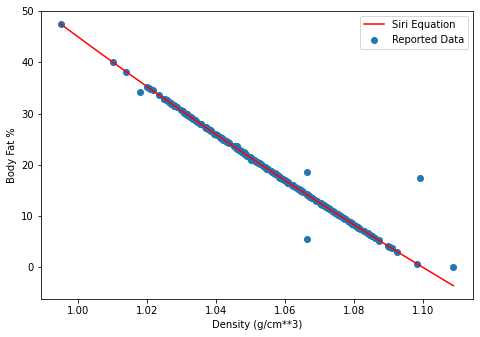

In [6]:
DensityBounds = np.linspace(min(df['Density']), max(df['Density']), 25)
SiriBP = [BodyFatP(i) for i in DensityBounds]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['Density'],df['BodyFat'])
ax.plot(DensityBounds,SiriBP,'r')

ax.set_xlabel('Density (g/cm**3)')
ax.set_ylabel('Body Fat %')
ax.legend(['Siri Equation', 'Reported Data'])
plt.show()

In [7]:
#finding the data that is off of the siri equation line
DensityPoints = df['Density']
BodyFatP_Points = df['BodyFat']

SiriBP_D = [BodyFatP(i) for i in DensityPoints]

df_Sc = df[['Density', 'BodyFat']]
df_Sc.insert(loc=2, column='BodyFatCalc',value=SiriBP_D)
series1 = df_Sc['BodyFat'] - df_Sc['BodyFatCalc']
df_Sc = df_Sc[abs(series1)>0.5]


print(df_Sc.shape)
df_Sc




(5, 3)


,Density,BodyFat,BodyFatCalc
47,1.0665,5.6,14.135021
75,1.0666,18.5,14.091506
95,1.0991,17.4,0.368483
168,1.0180,34.3,36.247544
181,1.1089,0.0,-3.611687


In [8]:
#df_clean has removed the 5 points found above

df_clean = df[abs(series1)<.5]


Visual confirmation that data was removed successfully


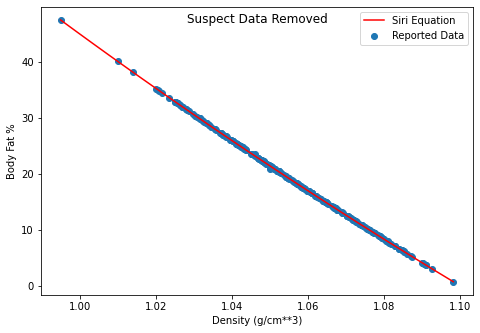

In [9]:
print('Visual confirmation that data was removed successfully')
DensityBounds = np.linspace(min(df_clean['Density']), max(df_clean['Density']), 25)
SiriBP = [BodyFatP(i) for i in DensityBounds]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_clean['Density'],df_clean['BodyFat'])
ax.plot(DensityBounds,SiriBP,'r')

ax.set_xlabel('Density (g/cm**3)')
ax.set_ylabel('Body Fat %')
ax.legend(['Siri Equation', 'Reported Data'])
fig.suptitle('Suspect Data Removed', fontsize=12)
plt.show()

In [10]:
#Inserting a BMI Feature
df_clean.insert(loc=2, column='BMI',value=calc_BMI(df_clean['Height'],df_clean['Weight']))
df_clean.sort_values(by='BMI', ascending=False).head()

,Density,BodyFat,BMI,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
41,1.0250,32.9,165.601839,44,205.00,29.50,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4
38,1.0202,35.2,48.906397,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
40,1.0217,34.5,39.079828,45,262.75,68.75,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4
215,0.9950,47.5,37.587158,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4
241,1.0207,35.0,33.881791,65,224.50,68.25,38.8,119.6,118.0,114.3,61.3,42.1,23.4,34.9,30.1,19.4


In [11]:
# #Using the BMI feature to count Obesity in the data and for outlier checks
# print('min BMI in data ' + str(min(df_clean['BMI'])))
# print('max BMI in data ' + str(max(df_clean['BMI'])))

df_cleaner = df_clean[df_clean['BMI']<100] #remove the outlying data


df_cleaner is the master dataframe in which all obviously outlying datapoints are removed. The code and cleaning procedure can be seen in the course 1 directory.



In [12]:
#next will be to construct a pairplot to examine feature association
#sns.pairplot(df_cleaner[df_cleaner['BMI']<25])

In [13]:
def check_skew(df):
    """function to check the normality of the float columns of a dataframe.
        Uses D'Agostino's K-Squared test"""
    skewlist = []
    vallist = []
    X_cols = df.select_dtypes(include = 'float').columns.to_list()

    for col in X_cols:
        ob = normaltest(df[col])
        if ob.pvalue < 0.05:
            skewlist.append(col)
            vallist.append(min(df[col])) #keep track of min value to ensure we are only working with nonnegative data
    return skewlist, vallist       


### Begin Unsupervised Learning Exercise

In [14]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from sklearn.preprocessing import StandardScaler

In [15]:
df_coef = pd.DataFrame() #initialize dataframe to store R2 coefficients for comparison
len_list = []

In [16]:
#I have previously done some work justifying the two outlying ankly data points.  The pairplot can be used to visually confirm.
df_cleaner = df_cleaner[df_cleaner['Ankle']<28]
df = df_cleaner.copy() #df used to check skews and normalize 


df_bmi=df_cleaner.copy() #keep this copy before all the transformations so that 
#list of groups can be appended to a human interpretable version

In [71]:
X_data = df_cleaner.drop(columns=['BodyFat', 'Density'])
skew,_=check_skew(X_data)
Y_data = df_cleaner['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

s = StandardScaler()

X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)




print('Lasso Regression')

#Use the lassoCV function to tune alpha


lassoCV = LassoCV(alphas=np.linspace(.00065,.0065,20),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha = lassoCV.alpha_
print('alpha = ', alpha)


y_pred_lasso = lassoCV.predict(X_test_s)
r2=r2_score(y_test,y_pred_lasso)

try:
    df_coef['NO_Cluster'] =[r2]
    len_list.append(len(X_data))
except:
    pass 

print('r2 =', r2)

print(abs(lassoCV.coef_).sum())

Lasso Regression
alpha =  0.0052684210526315785
r2 = 0.6548973114559451
29.026434993413986


In [72]:
skew

['BMI', 'Weight', 'Chest', 'Abdomen', 'Hip', 'Forearm']

In [18]:
#this cell was a normalizing exercise that proved unnecessary at this stage when the unsupervised learning algorithms were being explored.

skewlist, vallist = check_skew(df)

print('columns with skew = ', skewlist)   


assert len([i for i in vallist if i < 0]) == 0 #make sure log transform is valid

df_norm = df.copy()
for x in skewlist:
    df_norm[x] = np.log(df[x]) 
    
c1, c2 = check_skew(df_norm)

print('skewed columns left after a log transform =', c1)

columns with skew =  ['BMI', 'Weight', 'Chest', 'Abdomen', 'Hip', 'Forearm']
skewed columns left after a log transform = ['Forearm']


#### The goal of the unsupervised models is to see if they can come up with the obese/ not obese split that is in line with the overweight definition at BMI = 25.   

#### In the supervised learning lab I used this fact to bin my data for the sake of normality.  It will be interesting to see if the algorithms come up with better splits.

#### Through trial and error I learned that not transforming  the skewed columns leads to outlier detection that is more in line with human judgement.  6 more overweight/obese men are classified as outliers when the DMDBSCAN alogithm is run without the data transformation. 

In [19]:
#df_bmi.skew().apply(abs).sort_values(ascending = False)
df_final = df_bmi.copy()
df = df_bmi.copy().drop(columns='BMI') #unnormalized data with the BMI column dropped -
#                                       I don't want to give any hints to the algorithm 

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#the combination of these two will reintroduce the DMDBSCAN algorithm

In [21]:
Xu = df.drop(columns=['Density','BodyFat']) #these are related to targets

s, l = check_skew(Xu)

for i in s:
    Xu[i] = np.log(Xu[i])

y = df['BodyFat']

s = StandardScaler() #normalizing is important for these distance based algorithms
X = s.fit_transform(Xu)

In [22]:
#this code is used to find the optimal epsilon
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

Text(0.5, 1.0, 'DMDBSCAN - epsilon')

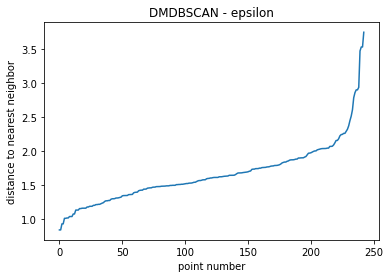

In [23]:
distances = np.sort(distances, axis=0) #sorts each points distance to neighbor
distances = distances[:,1] #keep the first nonzero entry of each row array
plt.plot(distances)

plt.xlabel('point number')
plt.ylabel('distance to nearest neighbor')
plt.title('DMDBSCAN - epsilon')

In [24]:
outliers=[]
ep=2.25
for i in range(1,25):
    dbs = DBSCAN(eps=ep,min_samples=i, metric='euclidean')
    dbs.fit(X)
    outliers.append(np.count_nonzero(dbs.labels_==-1))

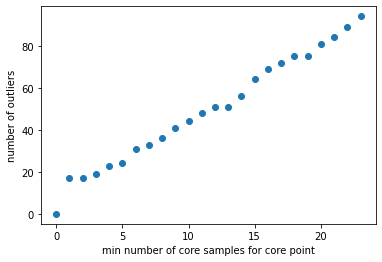

In [25]:
plt.plot(outliers,'o')
plt.xlabel('min number of core samples for core point')
plt.ylabel('number of outliers')
plt.show()

In [26]:
#fit the DBSCAN model with the optimized epsilon and min_samples

dbs = DBSCAN(eps=ep,min_samples=3, metric='euclidean')
dbs.fit(X)
print(np.count_nonzero(dbs.labels_==-1))
print(np.count_nonzero(dbs.labels_!=-1))
print(np.unique(dbs.labels_))



17
226
[-1  0]


In [27]:
#add the cluster labels into the original dataset.  This is so we have a shot at identifying what makes an outlier
df_final['Cluster_Assign_DB'] = dbs.labels_

#### The following cells are just to poke at the clustered data

In [28]:
#sns.pairplot(df_cluster.drop(['Density','BodyFat'],axis=1))

#![image.png](attachment:image.png)

In [75]:
df_cluster = df_bmi.copy()
df_cluster['Cluster_Assign_DB'] = dbs.labels_
df_cluster=df_cluster[df_cluster['Cluster_Assign_DB']==0]
df_cluster.drop(['Cluster_Assign_DB'],axis=1,inplace=True)

X_data = df_cluster.drop(columns=['BodyFat', 'Density'])
skew,_=check_skew(X_data)
Y_data = df_cluster['BodyFat']

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)



s=StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

print('Lasso Regression')

#Use the lassoCV function to come up with alpha


lassoCV = LassoCV(alphas=np.linspace(1e-6,.1e-4,200),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha = lassoCV.alpha_
print('alpha = ', alpha)


y_pred_lasso = lassoCV.predict(X_test_s)
r2=r2_score(y_test,y_pred_lasso)
try: 
    df_coef['DBSCAN'] =[r2]
    len_list.append(len(X_data))
except:
    pass
print('r2 =', r2)

print(abs(lassoCV.coef_).sum())

Lasso Regression
alpha =  1e-05
r2 = 0.7037971581363891
42.22904041186014


In [76]:
skew

['BMI', 'Weight', 'Chest']

In [66]:
check_skew(X_data)

(['BMI', 'Weight', 'Chest'], [19.225921521997623, 125.0, 83.4])

In [30]:
lasc = lassoCV.coef_
cols = X_data.columns.to_list()
noPFdf = pd.DataFrame(lasc,cols)

noPFdf[0].abs().sort_values(ascending=False)

BMI        9.364777
Weight     9.246741
Abdomen    7.449869
Height     5.087552
Hip        2.573838
Thigh      1.623398
Wrist      1.445356
Biceps     1.424410
Age        1.291341
Neck       0.858249
Chest      0.722252
Knee       0.698477
Forearm    0.346246
Ankle      0.096534
Name: 0, dtype: float64

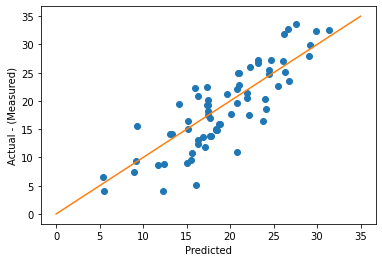

In [31]:
plt.plot(y_pred_lasso,y_test,'o',[0,35],[0,35])
plt.xlabel('Predicted')
plt.ylabel('Actual - (Measured)')
plt.show()

# KMEANS

In [32]:
from sklearn.cluster import KMeans

In [33]:
Xu = df.drop(columns=['Density','BodyFat']) #these are related to targets
skewlist,_= check_skew(Xu)

for i in skewlist:
    Xu[i]=np.log(Xu[i])

y = df['BodyFat']

s = StandardScaler()
X = s.fit_transform(Xu)

In [34]:
k2 = KMeans(n_clusters=2,random_state=42)

k2.fit(X)

KMeans(n_clusters=2, random_state=42)

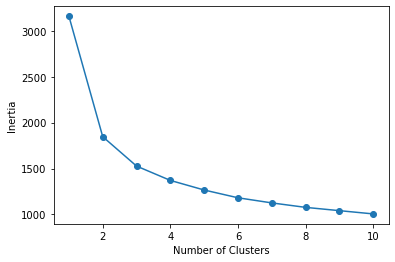

In [35]:

inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');


In [36]:
df_final['Cluster_Assign_kmeans'] = k2.labels_

In [37]:

#training regression model on kmeans cluster - with the high bmi group
#I set a random state to the kmeans object.  Hopefully this deals with the arbitrary 0/1 labels

df_kmeans=df_bmi.copy()
df_kmeans['Cluster_Assign_kmeans'] = k2.labels_

df_kr = df_kmeans[df_kmeans['Cluster_Assign_kmeans']==0]

df_cluster = df_kr.drop(columns = ['Cluster_Assign_kmeans'])

X_data = df_cluster.drop(columns=['BodyFat', 'Density'])
Y_data = df_cluster['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

s = StandardScaler()

X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

print('Lasso Regression')

#Use the lassoCV function to come up with alpha


lassoCV = LassoCV(alphas=np.linspace(.1,.5,200),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha = lassoCV.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV.predict(X_test_s)

r2=r2_score(y_test,y_pred_lasso)
try: 
    df_coef['kmeans'] = [r2]
    len_list.append(len(X_data))
except:    
    pass

print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV.coef_).sum())

lassoCV.score(X_test_s,y_test)

Lasso Regression
alpha =  0.15226130653266334
r2 = 0.45666263792061157
8.822522122797691


0.45666263792061157

In [67]:

#training regression model on kmeans cluster - with the low bmi group

df_kmeans=df_bmi.copy()
df_kmeans['Cluster_Assign_kmeans'] = k2.labels_

df_kr = df_kmeans[df_kmeans['Cluster_Assign_kmeans']==1]

df_cluster = df_kr.drop(columns = ['Cluster_Assign_kmeans'])

X_data = df_cluster.drop(columns=['BodyFat', 'Density'])
Y_data = df_cluster['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

s = StandardScaler()

X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

print('Lasso Regression')

#Use the lassoCV function to come up with alpha


lassoCV = LassoCV(alphas=np.linspace(.01,.5,200),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha = lassoCV.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV.predict(X_test_s)

r2=r2_score(y_test,y_pred_lasso)
try: 
    df_coef['kmeans'] = [r2]
    #len_list.append(len(X_data))
except:    
    pass

print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV.coef_).sum())

Lasso Regression
alpha =  0.46798994974874375
r2 = 0.6278570609242586
7.503587336758982


In [69]:
check_skew(X_data)

(['BMI', 'Weight', 'Chest', 'Hip', 'Biceps', 'Forearm', 'Wrist'],
 [22.02196878251821, 178.0, 95.4, 96.4, 30.5, 21.0, 17.0])

In [40]:
lasc = lassoCV.coef_
cols = X_data.columns.to_list()
noPFdf = pd.DataFrame(lasc,cols)

noPFdf[0].abs().sort_values(ascending=False)

Abdomen    5.568284
Wrist      0.655426
Age        0.652906
Height     0.626972
Forearm    0.000000
Biceps     0.000000
Ankle      0.000000
Knee       0.000000
Thigh      0.000000
Hip        0.000000
Chest      0.000000
Neck       0.000000
Weight     0.000000
BMI        0.000000
Name: 0, dtype: float64

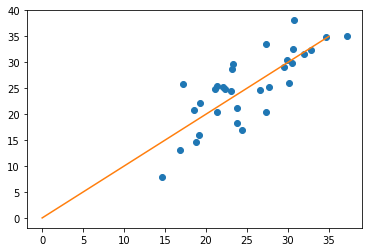

In [41]:
plt.plot(y_pred_lasso,y_test,'o',[0,35],[0,35])

## HA Clustering

In [42]:
from sklearn.cluster import AgglomerativeClustering

In [43]:
Xu = df.drop(columns=['Density','BodyFat']) #these are related to targets
y = df['BodyFat']

skewlist,_= check_skew(Xu)

for i in skewlist:
    Xu[i]=np.log(Xu[i])


s = StandardScaler() #normalizing is important for these distance based algorithms
X = s.fit_transform(Xu)

In [44]:
HA = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')

In [45]:
HA.fit(Xu) #training on unstandardized data leads to drastically better model performance - why
HA.labels_.sum()

67

In [46]:
df_final['Cluster_Assign_HA'] = HA.labels_

In [73]:
#training regression model on HA cluster

df_ha = df_bmi.copy()
df_ha['Cluster_Assign_HA'] = HA.labels_
df_ha_r = df_ha[df_ha['Cluster_Assign_HA']==0]

df_cluster = df_ha_r.drop(columns=['Cluster_Assign_HA'])

X_data = df_cluster.drop(columns=['BodyFat', 'Density'])
skew,_=check_skew(X_data)
Y_data = df_cluster['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=72018)

s = StandardScaler()

X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

print('Lasso Regression')

#Use the lassoCV function to come up with alpha


lassoCV = LassoCV(alphas=np.linspace(.15,.25,20),
                  max_iter=5e4,
                  cv=3).fit(X_train_s, y_train)

alpha = lassoCV.alpha_
print('alpha = ', alpha)

y_pred_lasso = lassoCV.predict(X_test_s)

r2=r2_score(y_test,y_pred_lasso)
df_coef['HA'] = r2
len_list.append(len(X_data))

print('r2 =', r2_score(y_test,y_pred_lasso))

print(abs(lassoCV.coef_).sum())

Lasso Regression
alpha =  0.1868421052631579
r2 = 0.7217672447946248
9.485850795297853


In [74]:
skew

['BMI', 'Chest', 'Forearm']

In [48]:
lasc = lassoCV.coef_
cols = X_data.columns.to_list()
noPFdf = pd.DataFrame(lasc,cols)

noPFdf[0].abs().sort_values(ascending=False)

Abdomen    6.449187
Height     1.160461
Thigh      0.922706
Ankle      0.480510
Wrist      0.428996
Neck       0.029024
Biceps     0.014968
Forearm    0.000000
Knee       0.000000
Hip        0.000000
Chest      0.000000
Weight     0.000000
Age        0.000000
BMI        0.000000
Name: 0, dtype: float64

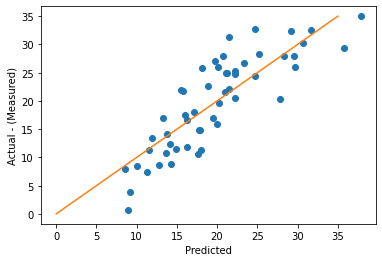

In [49]:
plt.plot(y_pred_lasso,y_test,'o',[0,35],[0,35])
plt.xlabel('Predicted')
plt.ylabel('Actual - (Measured)')
plt.show()

In [50]:
df_cluster.shape

(176, 16)

In [51]:
df_coef

,NO_Cluster,DBSCAN,kmeans,HA
0,0.654897,0.703797,0.627857,0.721767


In [52]:
#sns.pairplot(df_cluster.drop(['Density','BodyFat'],axis=1))
try:
    df_coef['HA'] = [r2]
except:
    df_coef.loc['HA'] = [r2]

df_coef = df_coef.T
df_coef.rename(columns={0:'R2'}, inplace=True)
df_coef['Length']=len_list

In [53]:
df_coef

,R2,Length
NO_Cluster,0.654897,243
DBSCAN,0.703797,226
kmeans,0.627857,137
HA,0.721767,176


In [54]:
df_final.to_csv('all2.csv')

In [55]:
#sns.pairplot(df_bmi)


# Polynomial Features Sandbox

not part of the main project, but may be used in future directions

In [56]:
from sklearn.preprocessing import PolynomialFeatures

In [57]:
bmi_corr = df_bmi.corr()

In [58]:
#check of how variables are correlated with the target in base case

bmi_corr['BodyFat'].abs().sort_values(ascending=False)

BodyFat    1.000000
Density    0.999738
Abdomen    0.821529
BMI        0.734194
Chest      0.696042
Hip        0.625044
Weight     0.612093
Thigh      0.531320
Knee       0.486602
Neck       0.480498
Biceps     0.468211
Forearm    0.345026
Wrist      0.332579
Age        0.297162
Ankle      0.281236
Height     0.023621
Name: BodyFat, dtype: float64

In [59]:
pf = PolynomialFeatures(degree=2)

In [60]:
df_low_corr_dropped=df_bmi.drop(columns=['Density','Age','Ankle','Height'])
pf1 = pf.fit_transform(df_low_corr_dropped)
intnames = pf.get_feature_names(df_low_corr_dropped.columns)
featuresdf = pd.DataFrame(pf1,columns=intnames)
corrdf=featuresdf.corr()['BodyFat'].abs().sort_values(ascending=False).to_frame()

In [61]:
for i in corrdf.index:
    if 'BodyFat' in i:
        corrdf.drop(i,inplace=True)

In [62]:
corrdf.drop('1',inplace=True) #remove degree 0 terms

In [63]:
corrdf.head(50)

,BodyFat
Abdomen,0.821529
Abdomen^2,0.817203
BMI Abdomen,0.784542
Chest Abdomen,0.782725
Abdomen Hip,0.771233
Abdomen Knee,0.751870
Neck Abdomen,0.749724
Abdomen Thigh,0.746188
BMI,0.734194
Abdomen Wrist,0.731265
